# Phase 4 Project — Prédiction de la maladie cardiaque
# Bootcamp / DataScience & IA
# Amee Hashley Jeudy / ameehashleyjeudy@gmail.com 


**Objectif.** Construire un modèle supervisé qui prédit la présence de maladie cardiaque (`target`: 1=malade, 0=sain) à partir de variables cliniques (âge, tension, cholestérol, ECG, etc.).

**Livrables.**
- Préparation des données (EDA, nettoyage, encodage, standardisation)
- Modèles comparés : *Logistic Regression*, *Random Forest*, *Gradient Boosting*
- Évaluation : Accuracy, Precision, Recall, F1, ROC-AUC, Matrice de confusion
- Interprétabilité : coefficients (LR) & importances (RF)
- Conclusion orientée usage (limites et pistes)


# 1) Imports & setup

In [1]:
# 1) Imports & setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Chargement et lecture
df = pd.read_csv("heart.csv")
print(df.shape)
df.head(10)

(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
5,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
6,58,1,0,114,318,0,2,140,0,4.4,0,3,1,0
7,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
8,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
9,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0


# 2) EDA & qualité des données

In [2]:
# 2) EDA & qualité
#Resume statistique et verification des valeurs manquantes
display(df.describe(include="all"))
print("Valeurs manquantes par colonne:\n", df.isna().sum())

# Distribution de la cible
print(df["target"].value_counts(normalize=True).rename("proportion"))



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Valeurs manquantes par colonne:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
target
1    0.513171
0    0.486829
Name: proportion, dtype: float64


# 3) Définition des features & split

In [3]:
# 3) Features & split

# Colonnes du dataset 
# ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']

target_col = "target"
X = df.drop(columns=[target_col])
y = df[target_col]

# Colonnes catégorielles codées en entiers (à one-hot encoder)
cat_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

len(X_train), len(X_test), y_train.mean(), y_test.mean()



(717, 308, 0.5132496513249651, 0.512987012987013)

# 4) Préprocesseur (encodage + standardisation)

In [4]:
# 4) Préprocesseur (ColumnTransformer)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

# Petit test: transformer un batch
_ = preprocess.fit(X_train)


# 5) Modèle 1 — Logistic Regression (baseline forte)

In [5]:
# 5) Logistic Regression
logreg_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

logreg_pipe.fit(X_train, y_train)
y_pred_lr = logreg_pipe.predict(X_test)
y_proba_lr = logreg_pipe.predict_proba(X_test)[:, 1]

lr_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "precision": precision_score(y_test, y_pred_lr),
    "recall": recall_score(y_test, y_pred_lr),
    "f1": f1_score(y_test, y_pred_lr),
    "roc_auc": roc_auc_score(y_test, y_proba_lr),
}
lr_metrics



{'accuracy': 0.8733766233766234,
 'precision': 0.8742138364779874,
 'recall': 0.879746835443038,
 'f1': 0.8769716088328076,
 'roc_auc': 0.9442194092827004}

# 6) Modèle 2 — Random Forest (+ tuning simple)

La Forêt Aléatoire capture des interactions non linéaires.

On tune quelques hyperparamètres clés (profondeur, nb d’arbres).

On optimise sur ROC-AUC (robuste à un léger déséquilibre).

In [6]:
# 6) Random Forest + tuning simple
rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(random_state=42))
])

rf_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5],
}

rf_cv = GridSearchCV(
    rf_pipe, rf_grid, cv=5, scoring="roc_auc", n_jobs=-1
)
rf_cv.fit(X_train, y_train)

best_rf = rf_cv.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

rf_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf),
    "recall": recall_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf),
    "roc_auc": roc_auc_score(y_test, y_proba_rf),
    "best_params": rf_cv.best_params_
}
rf_metrics


{'accuracy': 0.9805194805194806,
 'precision': 0.9810126582278481,
 'recall': 0.9810126582278481,
 'f1': 0.9810126582278481,
 'roc_auc': 0.9950632911392404,
 'best_params': {'clf__max_depth': 10,
  'clf__min_samples_split': 2,
  'clf__n_estimators': 400}}

# 7) Modèle 3 — Gradient Boosting (baseline boosting

In [7]:
# 7) Gradient Boosting 
gb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_pipe.fit(X_train, y_train)
y_pred_gb = gb_pipe.predict(X_test)
y_proba_gb = gb_pipe.predict_proba(X_test)[:, 1]

gb_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_gb),
    "precision": precision_score(y_test, y_pred_gb),
    "recall": recall_score(y_test, y_pred_gb),
    "f1": f1_score(y_test, y_pred_gb),
    "roc_auc": roc_auc_score(y_test, y_proba_gb),
}
gb_metrics


{'accuracy': 0.9642857142857143,
 'precision': 0.9565217391304348,
 'recall': 0.9746835443037974,
 'f1': 0.9655172413793104,
 'roc_auc': 0.9784388185654009}

# 8) Comparaison & courbes ROC

In [8]:
# 8) Comparaison & courbes ROC
# Tableau summary qui synthetise les metriques
summary = pd.DataFrame([lr_metrics, rf_metrics, gb_metrics],
                       index=["LogReg", "RandomForest(best)", "GradBoost"])
summary


,accuracy,precision,recall,f1,roc_auc,best_params
LogReg,0.873377,0.874214,0.879747,0.876972,0.944219,NaN
RandomForest(best),0.980519,0.981013,0.981013,0.981013,0.995063,"{'clf__max_depth': 10, 'clf__min_samples_split..."
GradBoost,0.964286,0.956522,0.974684,0.965517,0.978439,NaN


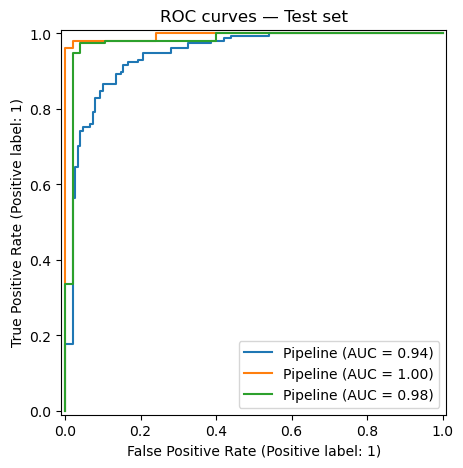

In [9]:
#Courbe ROC permettant de comparer visuellement la performance globale (AUC)
fig, ax = plt.subplots(figsize=(6, 5))
RocCurveDisplay.from_estimator(logreg_pipe, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(best_rf, X_test, y_test, ax=ax)
RocCurveDisplay.from_estimator(gb_pipe, X_test, y_test, ax=ax)
ax.set_title("ROC curves — Test set")
plt.show()


# 9) Matrices de confusion & rapport

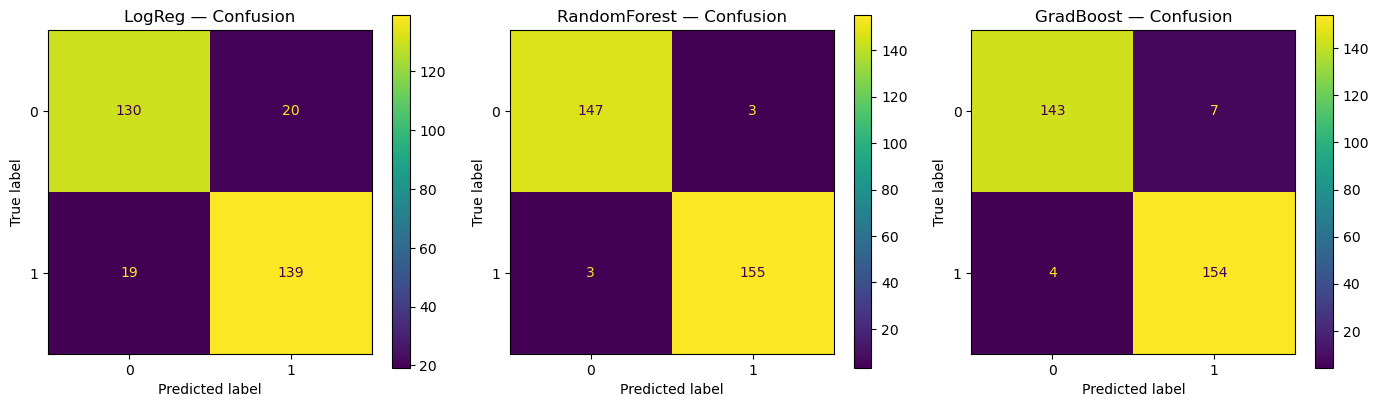

LogReg
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       150
           1       0.87      0.88      0.88       158

    accuracy                           0.87       308
   macro avg       0.87      0.87      0.87       308
weighted avg       0.87      0.87      0.87       308

RandomForest
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       150
           1       0.98      0.98      0.98       158

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308

GradBoost
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       150
           1       0.96      0.97      0.97       158

    accuracy                           0.96       308
   macro avg       0.96      0.96      0.96       308
weighted avg       0.96      0.96      0.

In [10]:
# 9) Matrices de confusion & rapports
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ConfusionMatrixDisplay.from_estimator(logreg_pipe, X_test, y_test, ax=axes[0])
axes[0].set_title("LogReg — Confusion")

ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, ax=axes[1])
axes[1].set_title("RandomForest — Confusion")

ConfusionMatrixDisplay.from_estimator(gb_pipe, X_test, y_test, ax=axes[2])
axes[2].set_title("GradBoost — Confusion")

plt.tight_layout()
plt.show()

print("LogReg\n", classification_report(y_test, y_pred_lr))
print("RandomForest\n", classification_report(y_test, y_pred_rf))
print("GradBoost\n", classification_report(y_test, y_pred_gb))


# 10) Interprétation des modèles

In [11]:
# 10.1) Coefficients de la régression logistique (après OneHot + Scaling)

# Récupérer les noms de features transformés
ohe = logreg_pipe.named_steps["prep"].named_transformers_["cat"]
num_names = num_cols
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
all_names = num_names + cat_names

coefs = pd.Series(logreg_pipe.named_steps["clf"].coef_[0], index=all_names).sort_values(ascending=False)
coefs.head(10), coefs.tail(10)


(ca_4       1.507346
 ca_0       1.327919
 sex_0      0.875880
 cp_3       0.747402
 cp_2       0.742352
 slope_2    0.623569
 thal_2     0.577419
 thal_1     0.525376
 exang_0    0.353521
 thalach    0.350872
 dtype: float64,
 thal_0     -0.414143
 trestbps   -0.419059
 oldpeak    -0.470938
 ca_3       -0.533303
 slope_1    -0.547460
 ca_1       -0.622342
 thal_3     -0.664919
 sex_1      -0.852147
 cp_0       -1.242748
 ca_2       -1.655886
 dtype: float64)

In [12]:
# 10.2) Importances de la RandomForest
importances = best_rf.named_steps["clf"].feature_importances_
rf_imp = pd.Series(importances, index=all_names).sort_values(ascending=False)
rf_imp.head(15)


cp_0        0.094142
thalach     0.091861
thal_2      0.088639
oldpeak     0.083518
ca_0        0.081485
age         0.078952
chol        0.062155
thal_3      0.060584
trestbps    0.059252
exang_1     0.042375
exang_0     0.039584
cp_2        0.025112
slope_2     0.024288
slope_1     0.018622
sex_1       0.018145
dtype: float64

## Conclusion & Recommandations

- **Performance** :
Trois modèles de classification ont été comparés sur les 308 observations du jeu de test :

Régression Logistique : AUC = 0.94 ; F1 = 0.88 ; Accuracy = 0.87

Gradient Boosting : AUC = 0.98 ; F1 = 0.97 ; Accuracy = 0.96

Random Forest (tuned) : AUC = 0.995 ; F1 = 0.98 ; Accuracy = 0.98

*Le meilleur modèle est donc la Random Forest optimisée, qui combine précision, rappel et robustesse, tout en maintenant une excellente AUC proche de 1 (0.995).
Cela indique une capacité quasi parfaite à distinguer les patients malades des non malades.

- **Variables clés** :
Selon la régression logistique : les variables les plus positivement associées au risque de maladie sont
ca_4, ca_0, sex_0, cp_3, cp_2, et thal_2.
Les variables protectrices sont notamment ca_2, cp_0, sex_1, et oldpeak.

Selon la Random Forest, les variables les plus importantes pour la décision sont :
cp_0 (type de douleur thoracique), thalach (fréquence cardiaque maximale), oldpeak (dépression ST), thal_2, et age.

Ces résultats confirment que les indicateurs cardiovasculaires classiques (tension, fréquence cardiaque, âge, anomalies ECG) sont déterminants dans la détection du risque.

- **Usage** :
Le modèle peut être intégré dans un outil d’aide à la décision médicale, pour :
détecter précocement les profils à risque ;
aider les cliniciens à prioriser les examens complémentaires ;
servir de base à un suivi préventif dans les campagnes de dépistage.

- **Limites** :
  - Données tabulaires classiques (pas d’images médicales)
  - Variables cliniques simplifiées (mesures ponctuelles, pas de séries temporelles)
  - Biais potentiels (population d’étude originale)
  - Aucune calibration spécifique du seuil décisionnel (probabilité = 0.5 utilisée par défaut).




- **Pistes d'amelioration** :
    - Calibration des probabilités pour ajuster le seuil selon la stratégie médicale (priorité au Recall pour minimiser les faux négatifs).
    - Exploration d’algorithmes avancés : XGBoost, LightGBM, ou réseaux de neurones légers.
    - Interprétabilité patient-par-patient via SHAP ou LIME, afin d’expliquer chaque prédiction médicale.
    - Extension du dataset avec des données réelles locales (hôpitaux, ministères, ONG santé) pour renforcer la validité externe du modèle.